## 1. Libraries 📖

In [1]:
import sys
sys.path.append('..')

import pandas as pd
import numpy as np
import pickle

import seaborn as sns
import matplotlib.pyplot as plt

from rdkit import Chem
from rdkit.Chem import AllChem

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import KFold
from sklearn.inspection import permutation_importance

from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import lightgbm as lgbm
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.svm import SVR


colors_palette = ['#ffa600','#ff6361','#bc5090','#58508d', '#65345a']
np.random.seed(1234)

## 2. Load data 📊

In [2]:
df_train = pd.read_csv("../../data/train/solubility/solub_maccs_train.csv")
df_test = pd.read_csv("../../data/train/solubility/solub_maccs_test.csv")
df_valid = pd.read_csv("../../data/train/solubility/solub_maccs_valid.csv")

In [3]:
df_train_all = pd.concat([df_train, df_valid])

In [4]:
X_train = df_train_all.loc[:, df_train_all.columns != 'solubility']
y_train = df_train_all['solubility']

X_test = df_test.loc[:, df_test.columns != 'solubility']
y_test = df_test['solubility']

In [5]:
X_train.shape, y_train.shape

((1410, 166), (1410,))

In [6]:
X_test.shape, y_test.shape

((353, 166), (353,))

## 3. Metrics 📏

In [7]:
def print_evaluate(true, predicted):  
    mae = mean_absolute_error(true, predicted)
    mse = mean_squared_error(true, predicted)
    rmse = np.sqrt(mean_squared_error(true, predicted))
    r2_square = r2_score(true, predicted)
    print('MAE:', mae)
    print('MSE:', mse)
    print('RMSE:', rmse)
    print('R2 Square', r2_square, '\n')
    
def evaluate(true, predicted):
    mae = mean_absolute_error(true, predicted)
    mse = mean_squared_error(true, predicted)
    rmse = np.sqrt(mean_squared_error(true, predicted))
    r2_square = r2_score(true, predicted)
    return mae, mse, rmse, r2_square

# 4. Models ⚙️

## 4.1. Ridge Regression

Poor results.

In [9]:
# default: 'alpha': 1.0, 'solver': 'auto', 'random_state': None, 
params = {
    'alpha': [1, 20, 50, 100],
    'solver': ['cholesky', 'svd','lsqr'],
    'tol': [0.001, 0.0001],
}

grid = GridSearchCV(Ridge(), params, scoring='r2', cv=5)
grid.fit(X_train, y_train)

ridge = Ridge(alpha=100, solver='cholesky', tol=0.0001)
ridge.fit(X_train, y_train)

ridge_tuned = grid.best_estimator_
r2_tuned = grid.best_params_

print("Best params: ", r2_tuned, '\n')

print('Test set:')
print('Tuned model:')
print_evaluate(y_test, ridge_tuned.predict(X_test))
print('Base model:')
print_evaluate(y_test, ridge.predict(X_test))
print('Train set:')
print('Tuned model:')
print_evaluate(y_train, ridge_tuned.predict(X_train))
print('Base model:')
print_evaluate(y_train, ridge.predict(X_train))

Best params:  {'alpha': 20, 'solver': 'lsqr', 'tol': 0.0001} 

Test set:
Tuned model:
MAE: 0.7259917609616943
MSE: 0.7528215711125845
RMSE: 0.867652909355224
R2 Square 0.1776093835484972 

Base model:
MAE: 0.7309637448861167
MSE: 0.74434516972776
RMSE: 0.8627544086979562
R2 Square 0.18686909823740272 

Train set:
Tuned model:
MAE: 0.664664578830067
MSE: 0.6557237925139661
RMSE: 0.8097677398575261
R2 Square 0.30028430932177974 

Base model:
MAE: 0.6988129372585439
MSE: 0.7082211609045155
RMSE: 0.8415587685387845
R2 Square 0.24426494140872668 



In [10]:
results_df = pd.DataFrame(data=[["Ridge Regression", *evaluate(y_test, ridge_tuned.predict(X_test))]],                           columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square'])
results_df

,Model,MAE,MSE,RMSE,R2 Square
0,Ridge Regression,0.725992,0.752822,0.867653,0.177609


## 4.2. Random Forest Regressor

Better results - first model.

'max_depth': None --> overfitting

In [18]:
# default: 'n_estimators': 100, 'max_depth': None
params = {
    'max_depth': [5, 10, 13, 15],
    'n_estimators': [500, 700, 1000],
}

grid = GridSearchCV(RandomForestRegressor(random_state=0), params, scoring='r2', cv=5)
grid.fit(X_train, y_train) 

rf_reg = RandomForestRegressor(random_state=0, max_depth=13)
rf_reg.fit(X_train, y_train)

rf_tuned = grid.best_estimator_
r2_tuned = grid.best_params_

print("Best params: ", r2_tuned, '\n')

print('Test set:')
print('Tuned model:')
print_evaluate(y_test, rf_tuned.predict(X_test))
print('Base model:')
print_evaluate(y_test, rf_reg.predict(X_test))
print('Train set:')
print('Tuned model:')
print_evaluate(y_train, rf_tuned.predict(X_train))
print('Base model:')
print_evaluate(y_train, rf_reg.predict(X_train))

Best params:  {'max_depth': 5, 'n_estimators': 700} 

Test set:
Tuned model:
MAE: 0.7002357583144511
MSE: 0.699433627722046
RMSE: 0.8363214858665572
R2 Square 0.2359309638017505 

Base model:
MAE: 0.639075713329713
MSE: 0.6241490513677912
RMSE: 0.7900310445595105
R2 Square 0.318172668254726 

Train set:
Tuned model:
MAE: 0.6514648515428432
MSE: 0.6160744233696605
RMSE: 0.7849040854586377
R2 Square 0.34259371769233626 

Base model:
MAE: 0.30720218697303997
MSE: 0.1419194286324275
RMSE: 0.37672195135461317
R2 Square 0.8485593291567465 



In [8]:
params = {'max_depth': 10, 'n_estimators': 500} 

rf_best = RandomForestRegressor(random_state=0, **params)
rf_best.fit(X_train, y_train)

print('Test set:')
print_evaluate(y_test, rf_best.predict(X_test))
print('Train set:')
print_evaluate(y_train, rf_best.predict(X_train))

Test set:
MAE: 0.6469075915913802
MSE: 0.6264382666492906
RMSE: 0.7914785320204778
R2 Square 0.31567190414436697 

Train set:
MAE: 0.39318678583504457
MSE: 0.2315582654848355
RMSE: 0.4812050139855522
R2 Square 0.7529067062752318 



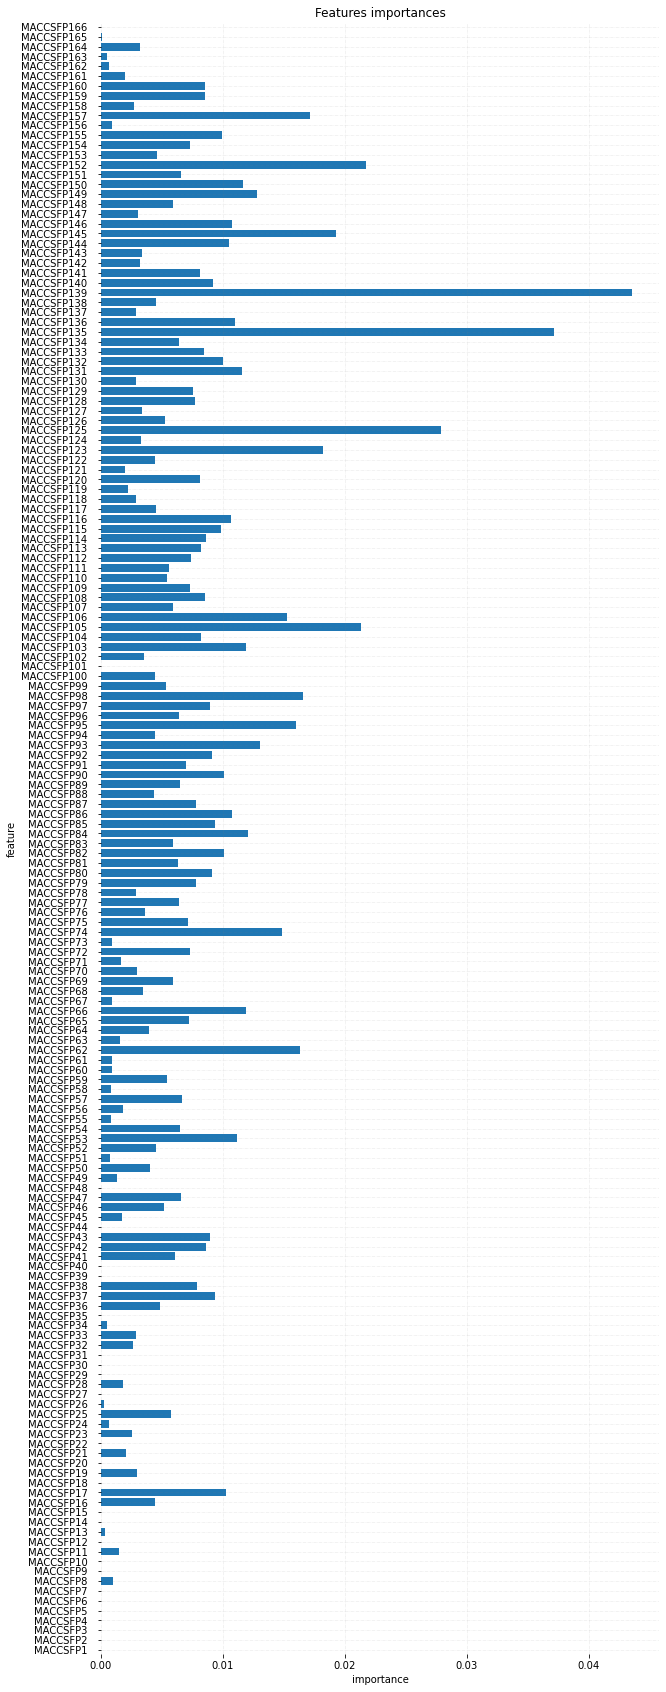

In [20]:
fig, ax = plt.subplots(figsize=(10, 30))
ax.barh(list(X_train.columns), rf_best.feature_importances_)

for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)
ax.yaxis.set_tick_params(pad=10)
plt.margins(y=0)
ax.grid(b=True, color='grey',linestyle='-.', linewidth=0.5,alpha=0.2)
ax.set_xlabel("importance")
ax.set_ylabel("feature")
ax.set_title("Features importances")
plt.show()

In [21]:
results_df = results_df.append(pd.DataFrame(data=[["Random Forest Regressor", *evaluate(y_test, rf_best.predict(X_test))]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square']), ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square
0,Ridge Regression,0.725992,0.752822,0.867653,0.177609
1,Random Forest Regressor,0.646908,0.626438,0.791479,0.315672


## 4.3. XGBoost

Better results - second model.

'max_depth': None --> overfitting

In [29]:
# default: 'booster': gbtree, 'eta': 0.3, 'gamma': 0, 'max_depth': 6 
params = {
    'eta': [0.005, 0.01],
    'lambda': [0.4, 0.6, 0.8],
    'gamma': [0.1, 0.5, 0.8],
    'max_depth': [5, 10, 15],
    'n_estimators': [500, 1000, 2000, 3000],
    'min_child_weight': [55, 90, 125, 155],
    'colsample_bytree': [0.3],
    'subsample': [0.8, 0.9]   
} 

grid = GridSearchCV(xgb.XGBRegressor(verbosity=0), params, scoring='r2', cv=5)
grid.fit(X_train, y_train)

xgbr = xgb.XGBRegressor(verbosity=0, max_depth=5) 
xgbr.fit(X_train, y_train)

xgbr_tuned = grid.best_estimator_
r2_tuned = grid.best_params_

print("Best params: ", r2_tuned, '\n')

print('Test set:')
print('Tuned model:')
print_evaluate(y_test, xgbr_tuned.predict(X_test))
print('Base model:')
print_evaluate(y_test, xgbr.predict(X_test))
print('Train set:')
print('Tuned model:')
print_evaluate(y_train, xgbr_tuned.predict(X_train))
print('Base model:')
print_evaluate(y_train, xgbr.predict(X_train))


Best params:  {'colsample_bytree': 0.3, 'eta': 0.01, 'gamma': 0.1, 'lambda': 0.4, 'max_depth': 10, 'min_child_weight': 55, 'n_estimators': 2000, 'subsample': 0.9} 

Test set:
Tuned model:
MAE: 0.6380917464845026
MSE: 0.6239482108292681
RMSE: 0.7899039250625788
R2 Square 0.3183920686818955 

Base model:
MAE: 0.662337083596598
MSE: 0.6973179985304233
RMSE: 0.8350556858859314
R2 Square 0.23824210054629147 

Train set:
Tuned model:
MAE: 0.44709140583544976
MSE: 0.3075682772870415
RMSE: 0.5545883854599206
R2 Square 0.6717972536157 

Base model:
MAE: 0.19440658274518793
MSE: 0.07383512447379846
RMSE: 0.2717261939412512
R2 Square 0.9212113458329394 



In [30]:
params = {'colsample_bytree': 0.3, 'eta': 0.01, 'gamma': 0.1, 'lambda': 0.4, 'max_depth': 10, 
          'min_child_weight': 55, 'n_estimators': 1000, 'subsample': 0.9} 

xgbr_best = xgb.XGBRegressor(**params) 
xgbr_best.fit(X_train, y_train)

print('Test set:')
print_evaluate(y_test, xgbr_best.predict(X_test))
print('Train set:')
print_evaluate(y_train, xgbr_best.predict(X_train))

Test set:
MAE: 0.6466989382223464
MSE: 0.6275483365099244
RMSE: 0.7921794850347517
R2 Square 0.31445925154244736 

Train set:
MAE: 0.5286098005643269
MSE: 0.4222605538938388
RMSE: 0.6498157845834762
R2 Square 0.549410379054223 



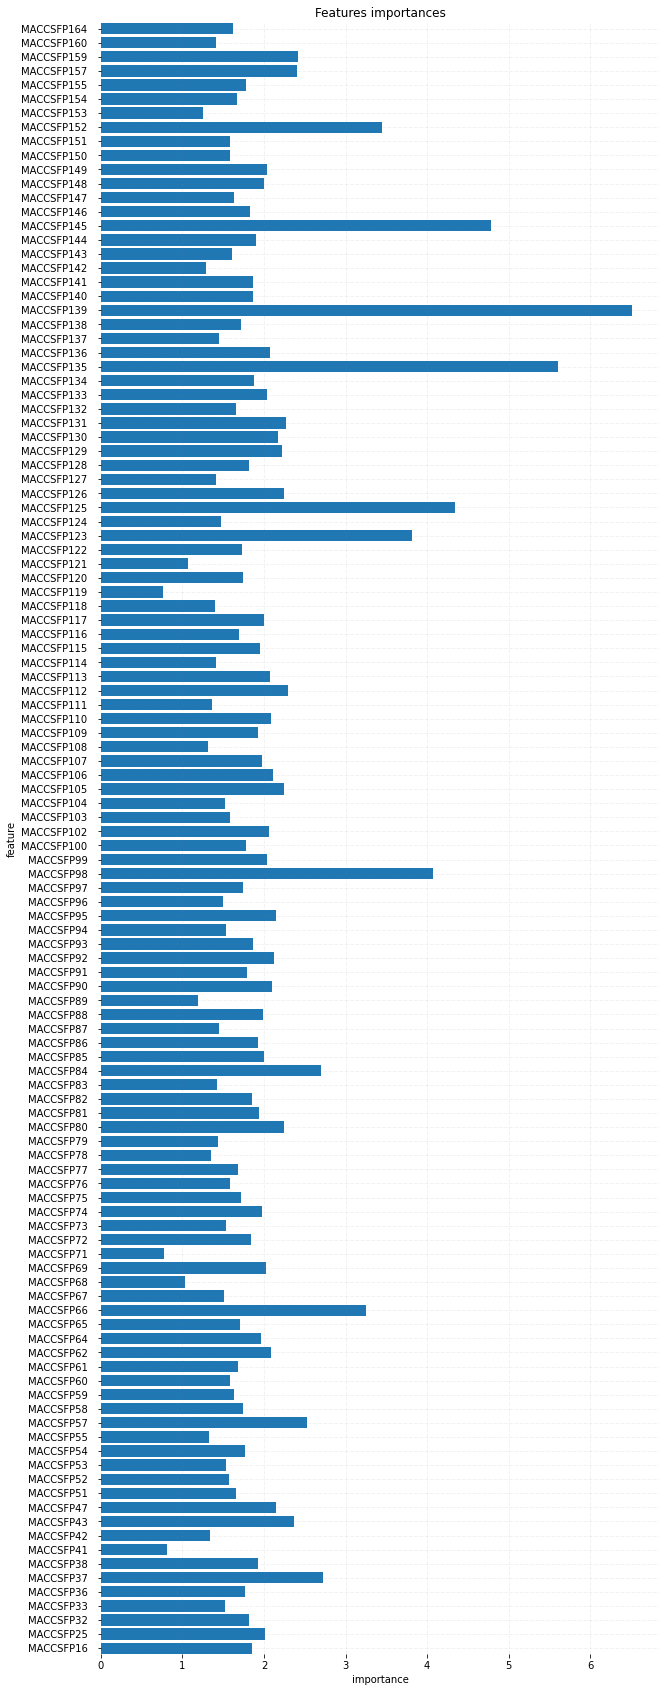

In [31]:
feature_importance = xgbr_best.get_booster().get_score(importance_type='gain')
keys = list(feature_importance.keys())
values = list(feature_importance.values())

fig, ax = plt.subplots(figsize=(10, 30))
ax.barh(keys, values)

for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)
ax.yaxis.set_tick_params(pad=10)
plt.margins(y=0)
ax.grid(b=True, color='grey',linestyle='-.', linewidth=0.5,alpha=0.2)
ax.set_xlabel("importance")
ax.set_ylabel("feature")
ax.set_title("Features importances")
plt.show()

In [32]:
results_df = results_df.append(pd.DataFrame(data=[["XGBoost", *evaluate(y_test, xgbr_best.predict(X_test))]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square']), ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square
0,Ridge Regression,0.725992,0.752822,0.867653,0.177609
1,Random Forest Regressor,0.646908,0.626438,0.791479,0.315672
2,XGBoost,0.646699,0.627548,0.792179,0.314459


## 4.4. LightGBM

Better results - third model.

In [37]:
# default: 'n_estimators': 100, 'num_leaves': 31, 'learning_rate': 0.1, 'max_depth': -1 
params = {
    'num_leaves': [50, 60, 70],
    'learning_rate': [0.001, 0.005, 0.01],
    'max_depth': [5, 10, 15],
    'n_estimators': [1000, 2000, 3000],
    'min_child_samples': [30, 50, 70, 100],
    'reg_alpha': [1.7, 2.7, 3.7],
    'reg_lambda': [0.05, 0.1],
    'colsample_bytree': [0.25],
    'subsample': [0.8],
    'cat_smooth': [28],
}

grid = GridSearchCV(lgbm.LGBMRegressor(random_state=0), params, scoring='r2', cv=5)
grid.fit(X_train, y_train)

lgbm_reg = lgbm.LGBMRegressor(random_state=0)
lgbm_reg.fit(X_train,y_train)

lgbm_tuned = grid.best_estimator_
r2_tuned = grid.best_params_

print("Best params: ", r2_tuned, '\n')

print('Test set:')
print('Tuned model:')
print_evaluate(y_test, lgbm_tuned.predict(X_test))
print('Base model:')
print_evaluate(y_test, lgbm_reg.predict(X_test))
print('Train set:')
print('Tuned model:')
print_evaluate(y_train, lgbm_tuned.predict(X_train))
print('Base model:')
print_evaluate(y_train, lgbm_reg.predict(X_train))

Best params:  {'cat_smooth': 28, 'colsample_bytree': 0.25, 'learning_rate': 0.01, 'max_depth': 15, 'min_child_samples': 50, 'n_estimators': 1000, 'num_leaves': 60, 'reg_alpha': 1.7, 'reg_lambda': 0.1, 'subsample': 0.8} 

Test set:
Tuned model:
MAE: 0.661625558631906
MSE: 0.6457260920870718
RMSE: 0.8035708382507866
R2 Square 0.29460167016004657 

Base model:
MAE: 0.6272606593063763
MSE: 0.6212730878304252
RMSE: 0.7882087844159219
R2 Square 0.3213144026538758 

Train set:
Tuned model:
MAE: 0.5679800465828232
MSE: 0.48484690815671583
RMSE: 0.6963094916462907
R2 Square 0.482625164608694 

Base model:
MAE: 0.33419070867799
MSE: 0.1756276469570771
RMSE: 0.419079523428522
R2 Square 0.8125896578777192 



In [38]:
params = {'cat_smooth': 28, 'colsample_bytree': 0.25, 'learning_rate': 0.01, 'max_depth': 15, 
          'min_child_samples': 50, 'n_estimators': 1000, 'num_leaves': 60, 'reg_alpha': 1.7, 'reg_lambda': 0.1, 
          'subsample': 0.8}

lgbm_best = lgbm.LGBMRegressor(**params) 
lgbm_best.fit(X_train, y_train)

print('Test set:')
print_evaluate(y_test, lgbm_best.predict(X_test))
print('Train set:')
print_evaluate(y_train, lgbm_best.predict(X_train))

Test set:
MAE: 0.660364045488943
MSE: 0.6411029644723042
RMSE: 0.8006890560462933
R2 Square 0.2996520259348202 

Train set:
MAE: 0.569549169599168
MSE: 0.4860888637399884
RMSE: 0.6972007341791806
R2 Square 0.48129988738273044 



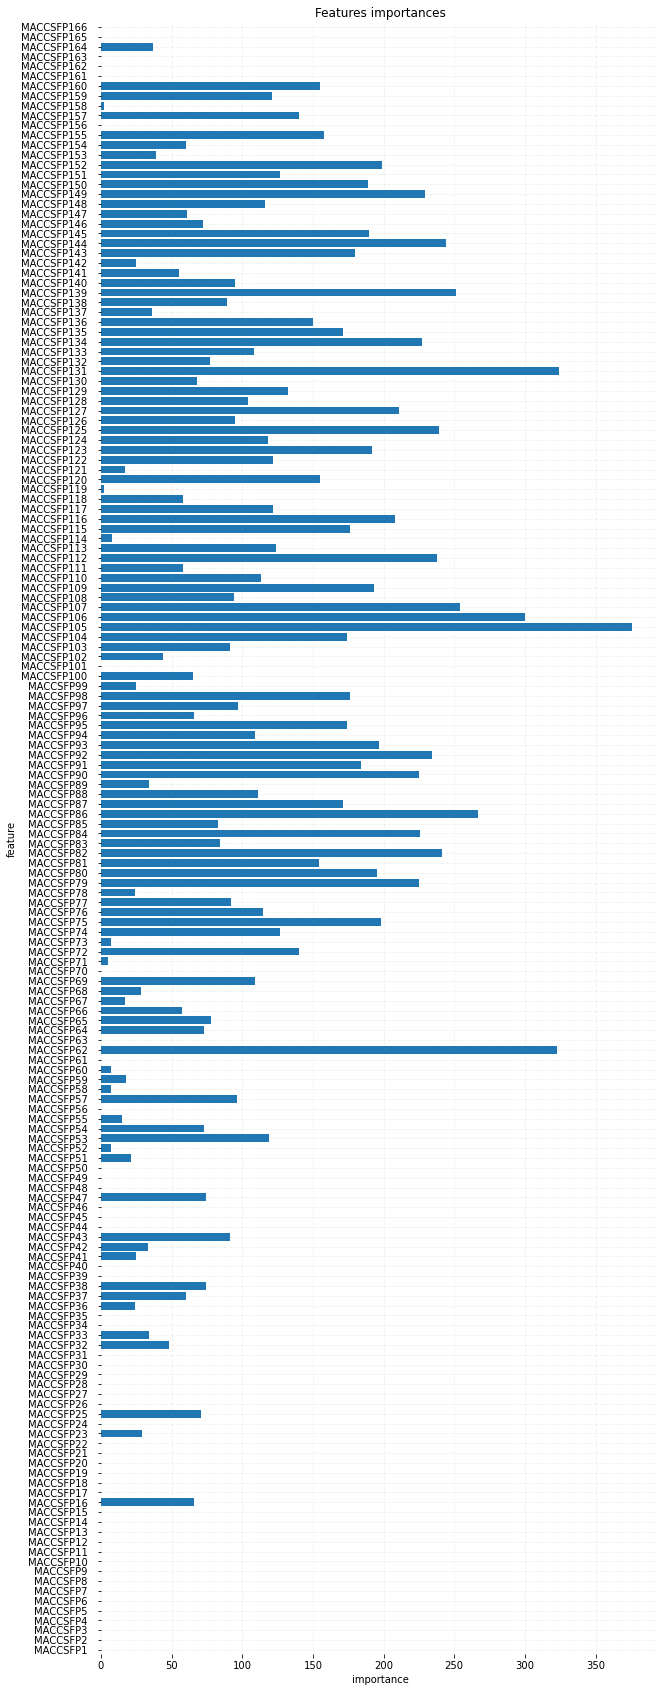

In [39]:
fig, ax = plt.subplots(figsize=(10, 30))
ax.barh(list(X_train.columns), lgbm_best.feature_importances_)

for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)
ax.yaxis.set_tick_params(pad=10)
plt.margins(y=0)
ax.grid(b=True, color='grey',linestyle='-.', linewidth=0.5,alpha=0.2)
ax.set_xlabel("importance")
ax.set_ylabel("feature")
ax.set_title("Features importances")
plt.show()

In [40]:
results_df = results_df.append(pd.DataFrame(data=[["LightGBM", *evaluate(y_test, lgbm_best.predict(X_test))]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square']), ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square
0,Ridge Regression,0.725992,0.752822,0.867653,0.177609
1,Random Forest Regressor,0.646908,0.626438,0.791479,0.315672
2,XGBoost,0.646699,0.627548,0.792179,0.314459
3,LightGBM,0.660364,0.641103,0.800689,0.299652


## 4.5. Histogram-based Gradient Boosting Regressor (Regression Tree)

Better results - fourth model.

In [42]:
# default: 'learning_rate': 0.1, 'max_depth': None , 'l2_regularization': 0
params = {
    'learning_rate': [0.005, 0.1, 0.15],
    'max_depth': [5, 10, 15, 25, 35, 40],
    'l2_regularization': [0, 0.01, 0.05],
    'min_samples_leaf':[10, 15, 20, 25],
}

grid = GridSearchCV(HistGradientBoostingRegressor(random_state=0), params, scoring='r2', cv=5)
grid.fit(X_train, y_train)

hist_reg = HistGradientBoostingRegressor(random_state=0)
hist_reg.fit(X_train,y_train)

hist_tuned = grid.best_estimator_
r2_tuned = grid.best_params_

print("Best params: ", r2_tuned, '\n')

print('Test set:')
print('Tuned model:')
print_evaluate(y_test, hist_tuned.predict(X_test))
print('Base model:')
print_evaluate(y_test, hist_reg.predict(X_test))
print('Train set:')
print('Tuned model:')
print_evaluate(y_train, hist_tuned.predict(X_train))
print('Base model:')
print_evaluate(y_train, hist_reg.predict(X_train))

Best params:  {'l2_regularization': 0.01, 'learning_rate': 0.1, 'max_depth': 25, 'min_samples_leaf': 55} 

Test set:
Tuned model:
MAE: 0.6359305898979593
MSE: 0.6263361979663005
RMSE: 0.7914140496391888
R2 Square 0.31578340510335323 

Base model:
MAE: 0.6272606589379556
MSE: 0.6212730885822256
RMSE: 0.7882087848928262
R2 Square 0.32131440183260085 

Train set:
Tuned model:
MAE: 0.46297443182492
MSE: 0.32669002750181625
RMSE: 0.5715680427576547
R2 Square 0.6513926429987646 

Base model:
MAE: 0.33419070812130575
MSE: 0.17562764652427246
RMSE: 0.4190795229121467
R2 Square 0.8125896583395603 



In [43]:
params = {'l2_regularization': 0.01, 'learning_rate': 0.1, 'max_depth': 25, 'min_samples_leaf': 55} 

hist_best = HistGradientBoostingRegressor(random_state=0, **params) 
hist_best.fit(X_train, y_train)

print('Test set:')
print_evaluate(y_test, hist_best.predict(X_test))
print('Train set:')
print_evaluate(y_train, hist_best.predict(X_train))

Test set:
MAE: 0.6359305898979593
MSE: 0.6263361979663005
RMSE: 0.7914140496391888
R2 Square 0.31578340510335323 

Train set:
MAE: 0.46297443182492
MSE: 0.32669002750181625
RMSE: 0.5715680427576547
R2 Square 0.6513926429987646 



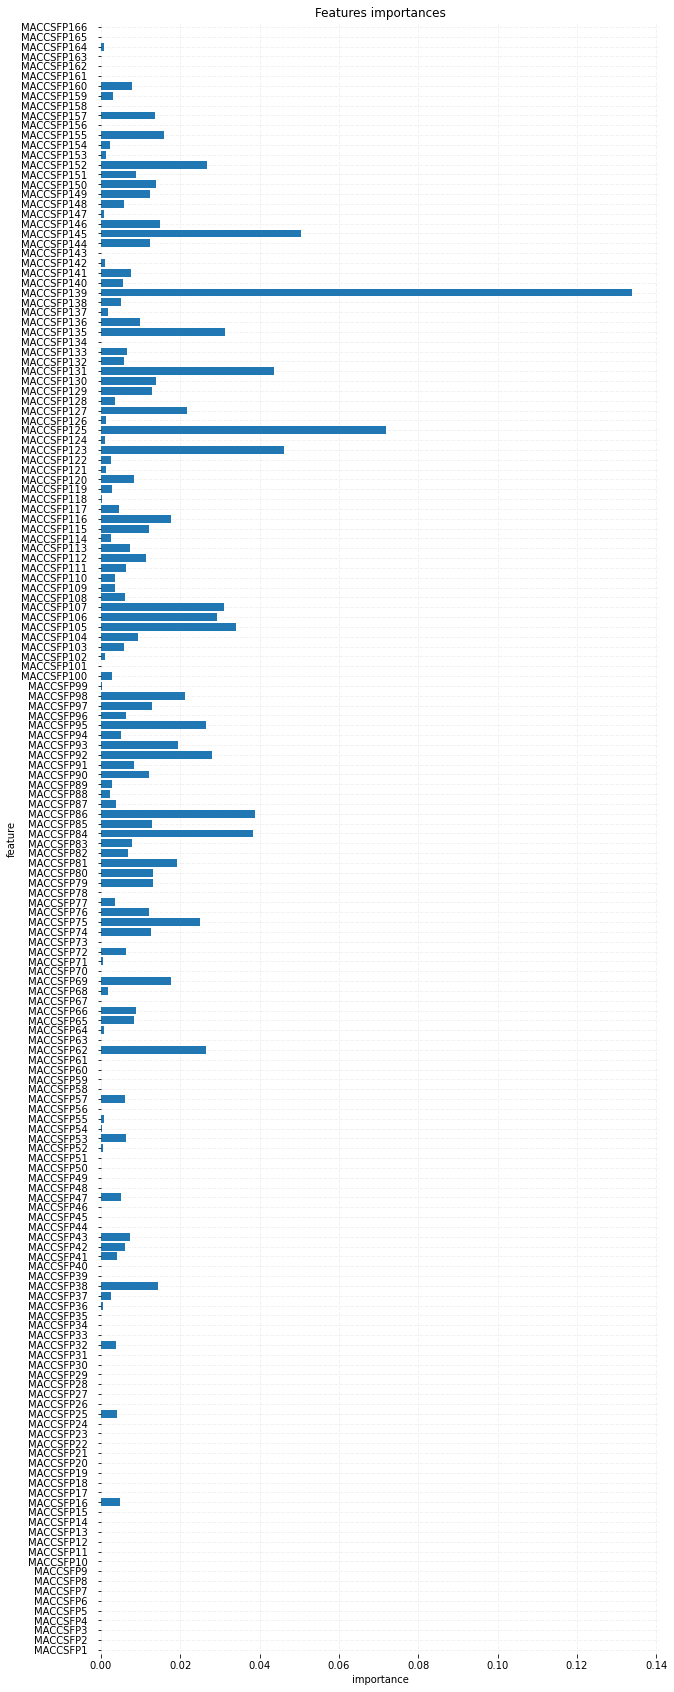

In [44]:
feature_importance = permutation_importance(hist_best, X_train, y_train, n_repeats=15, random_state=0)
fig, ax = plt.subplots(figsize=(10, 30))
ax.barh(list(X_train.columns), feature_importance.importances_mean)

for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)
ax.yaxis.set_tick_params(pad=10)
plt.margins(y=0)
ax.grid(b=True, color='grey',linestyle='-.', linewidth=0.5,alpha=0.2)
ax.set_xlabel("importance")
ax.set_ylabel("feature")
ax.set_title("Features importances")
plt.show()

In [45]:
results_df = results_df.append(pd.DataFrame(data=[["HistGradient Boosting Regressor", *evaluate(y_test, hist_best.predict(X_test))]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square']), ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square
0,Ridge Regression,0.725992,0.752822,0.867653,0.177609
1,Random Forest Regressor,0.646908,0.626438,0.791479,0.315672
2,XGBoost,0.646699,0.627548,0.792179,0.314459
3,LightGBM,0.660364,0.641103,0.800689,0.299652
4,HistGradient Boosting Regressor,0.635931,0.626336,0.791414,0.315783


## 4.6. Support Vector Regression

Better results - fifth model.

In [59]:
# default: 'kernel': 'rbf', 'gamma': 'scale', 'C': 1.0, 'epsilon': 0.1
params = {
    'kernel': ['rbf', 'sigmoid'],
    'gamma': ['scale', 'auto'],
    'C': [5.0, 15.0, 30.0],
    'epsilon': [0.1, 0.8, 1.0, 2.8],
}

grid = GridSearchCV(SVR(), params, scoring='r2', cv=5)
grid.fit(X_train, y_train)

svr = SVR()
svr.fit(X_train,y_train)

svr_tuned = grid.best_estimator_
r2_tuned = grid.best_params_

print("Best params: ", r2_tuned, '\n')

print('Test set:')
print('Tuned model:')
print_evaluate(y_test, svr_tuned.predict(X_test))
print('Base model:')
print_evaluate(y_test, svr.predict(X_test))
print('Train set:')
print('Tuned model:')
print_evaluate(y_train, svr_tuned.predict(X_train))
print('Base model:')
print_evaluate(y_train, svr.predict(X_train))

Best params:  {'C': 5.0, 'epsilon': 0.8, 'gamma': 'scale', 'kernel': 'rbf'} 

Test set:
Tuned model:
MAE: 0.6727433980497648
MSE: 0.655632120988508
RMSE: 0.8097111342871036
R2 Square 0.2837802145489928 

Base model:
MAE: 0.663958644188032
MSE: 0.6845091434694711
RMSE: 0.8273506774454658
R2 Square 0.2522346355822451 

Train set:
Tuned model:
MAE: 0.541561194098785
MSE: 0.37554649351087965
RMSE: 0.6128184833299986
R2 Square 0.5992584422149785 

Base model:
MAE: 0.4700145969556486
MSE: 0.40377634225650066
RMSE: 0.635433979463249
R2 Square 0.56913467922469 



In [60]:
params = {'C': 5.0, 'epsilon': 0.8, 'gamma': 'scale', 'kernel': 'rbf'} 

svr_best = SVR(**params) 
svr_best.fit(X_train, y_train)

print('Test set:')
print_evaluate(y_test, svr_best.predict(X_test))
print('Train set:')
print_evaluate(y_train, svr_best.predict(X_train))

Test set:
MAE: 0.6727433980497648
MSE: 0.655632120988508
RMSE: 0.8097111342871036
R2 Square 0.2837802145489928 

Train set:
MAE: 0.541561194098785
MSE: 0.37554649351087965
RMSE: 0.6128184833299986
R2 Square 0.5992584422149785 



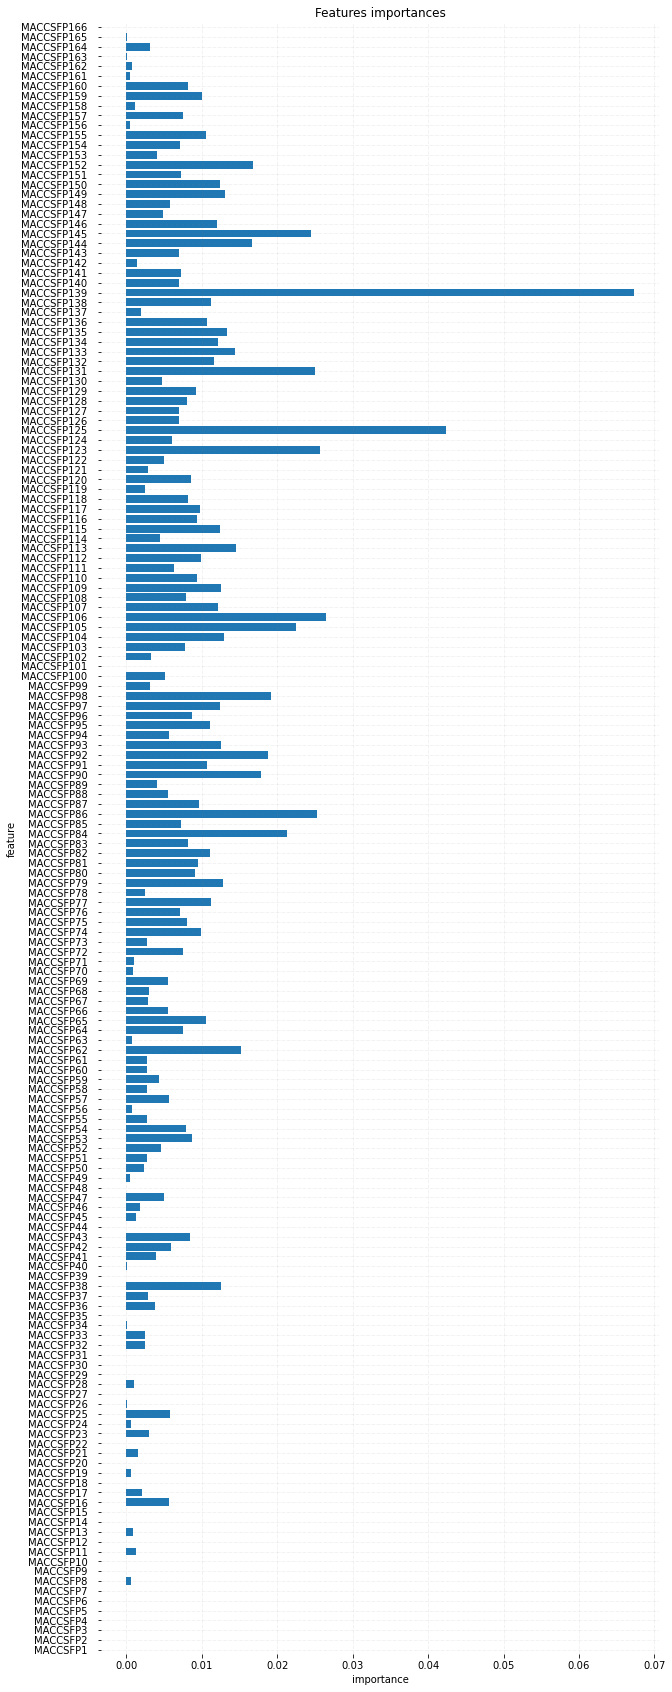

In [61]:
feature_importance = permutation_importance(svr_best, X_train, y_train, n_repeats=5, random_state=0)
fig, ax = plt.subplots(figsize=(10, 30))
ax.barh(list(X_train.columns), feature_importance.importances_mean)

for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)
ax.yaxis.set_tick_params(pad=10)
plt.margins(y=0)
ax.grid(b=True, color='grey',linestyle='-.', linewidth=0.5,alpha=0.2)
ax.set_xlabel("importance")
ax.set_ylabel("feature")
ax.set_title("Features importances")
plt.show()

In [62]:
results_df = results_df.append(pd.DataFrame(data=[["Support Vector Regression", *evaluate(y_test, svr_best.predict(X_test))]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square']), ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square
0,Ridge Regression,0.725992,0.752822,0.867653,0.177609
1,Random Forest Regressor,0.646908,0.626438,0.791479,0.315672
2,XGBoost,0.646699,0.627548,0.792179,0.314459
3,LightGBM,0.660364,0.641103,0.800689,0.299652
4,HistGradient Boosting Regressor,0.635931,0.626336,0.791414,0.315783
5,Support Vector Regression,0.672743,0.655632,0.809711,0.283780


### Save models

In [9]:
'''
pickle.dump(rf_best, open('models/rf.pkl', 'wb'))
pickle.dump(xgbr_best, open('models/xgb.pkl', 'wb'))
pickle.dump(lgbm_best, open('models/lgbm.pkl', 'wb'))
pickle.dump(hist_best, open('models/hist.pkl', 'wb'))
pickle.dump(svr_best, open('models/svr.pkl', 'wb'))
'''
pickle.dump(rf_best, open('../../models/solub_maccs_rf_model.pkl', 'wb'))

## 4.7. Stacking models

### Averaging base models

In [63]:
def average_predictions(X):
    return ((0.20 * rf_best.predict(X)) + \
            (0.20 * xgbr_best.predict(X)) + \
            (0.20 * lgbm_best.predict(X)) + \
            (0.20 * hist_best.predict(X)) + \
            (0.20 * svr_best.predict(X)))

print('Test set:')
print_evaluate(y_test, average_predictions(X_test))
print('Train set:')
print_evaluate(y_train, average_predictions(X_train))

Test set:
MAE: 0.6433591995235443
MSE: 0.6169147325763793
RMSE: 0.7854391972497803
R2 Square 0.3260755181713182 

Train set:
MAE: 0.49228404713657326
MSE: 0.34769108363646084
RMSE: 0.5896533588782996
R2 Square 0.6289826455791393 



In [64]:
results_df = results_df.append(pd.DataFrame(data=[["Averaging base models", *evaluate(y_test, average_predictions(X_test))]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square']), ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square
0,Ridge Regression,0.725992,0.752822,0.867653,0.177609
1,Random Forest Regressor,0.646908,0.626438,0.791479,0.315672
2,XGBoost,0.646699,0.627548,0.792179,0.314459
3,LightGBM,0.660364,0.641103,0.800689,0.299652
4,HistGradient Boosting Regressor,0.635931,0.626336,0.791414,0.315783
5,Support Vector Regression,0.672743,0.655632,0.809711,0.283780
6,Averaging base models,0.643359,0.616915,0.785439,0.326076


### Averaging base models with Meta-model

In [65]:
meta_train = pd.DataFrame(data={
    "rf": rf_best.predict(X_train).tolist(),
    "xgbr": xgbr_best.predict(X_train).tolist(),
    "lgbm": lgbm_best.predict(X_train).tolist(),
    "hist_reg": hist_best.predict(X_train).tolist(),
    "svr_reg": svr_best.predict(X_train).tolist()
    })

    
meta_test = pd.DataFrame(data={
    "rf": rf_best.predict(X_test).tolist(),
    "xgbr": xgbr_best.predict(X_test).tolist(),
    "lgbm": lgbm_best.predict(X_test).tolist(),
    "hist_reg": hist_best.predict(X_test).tolist(),
    "svr_reg": svr_best.predict(X_test).tolist()
    })


In [66]:
meta_train

,rf,xgbr,lgbm,hist_reg,svr_reg
0,4.476898,4.363758,4.404994,4.597405,4.109944
1,4.925878,4.823828,4.917326,4.964815,4.703345
2,3.994514,3.953873,3.970798,3.893901,4.167276
3,4.118375,4.037802,4.082264,4.063875,4.209064
4,5.323694,5.301939,5.213039,5.632845,5.352082
...,...,...,...,...,...
1405,5.294245,5.221590,5.048296,5.354996,5.123458
1406,3.790914,3.747017,3.775812,3.656899,4.068171
1407,4.439934,4.551775,4.652692,4.276421,4.718126
1408,5.232599,5.049170,4.930125,5.104753,5.024219


In [74]:
params = {'alpha': 0.3} 

meta_model = Ridge(**params)
meta_model.fit(meta_train, y_train)

print('Test set:')
print_evaluate(y_test, meta_model.predict(meta_test))

print('Train set:')
print_evaluate(y_train, meta_model.predict(meta_train))

Test set:
MAE: 0.6513691169003816
MSE: 0.6616339939311742
RMSE: 0.8134088725426925
R2 Square 0.27722370211818115 

Train set:
MAE: 0.2652994786315601
MSE: 0.11600384344749438
RMSE: 0.3405933696469947
R2 Square 0.8762135668007458 



In [75]:
results_df = results_df.append(pd.DataFrame(data=[["Base models + Meta-model", *evaluate(y_test, meta_model.predict(meta_test))]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square']), ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square
0,Ridge Regression,0.725992,0.752822,0.867653,0.177609
1,Random Forest Regressor,0.646908,0.626438,0.791479,0.315672
2,XGBoost,0.646699,0.627548,0.792179,0.314459
3,LightGBM,0.660364,0.641103,0.800689,0.299652
4,HistGradient Boosting Regressor,0.635931,0.626336,0.791414,0.315783
5,Support Vector Regression,0.672743,0.655632,0.809711,0.283780
6,Averaging base models,0.643359,0.616915,0.785439,0.326076
7,Base models + Meta-model,0.651369,0.661634,0.813409,0.277224


### Averaging base models with Meta-model and k-fold cross validation

![Stacked](images/stacked.png)

In [76]:
params_rf = {'max_depth': 10, 'n_estimators': 500} 

params_xgb = {'colsample_bytree': 0.3, 'eta': 0.01, 'gamma': 0.1, 'lambda': 0.4, 'max_depth': 10, 
          'min_child_weight': 55, 'n_estimators': 1000, 'subsample': 0.9}  

params_lgbm = {'cat_smooth': 28, 'colsample_bytree': 0.25, 'learning_rate': 0.01, 'max_depth': 15, 
          'min_child_samples': 50, 'n_estimators': 1000, 'num_leaves': 60, 'reg_alpha': 1.7, 'reg_lambda': 0.1, 
          'subsample': 0.8}

params_hist =  {'l2_regularization': 0.01, 'learning_rate': 0.1, 'max_depth': 25, 'min_samples_leaf': 55} 

params_svr = {'C': 5.0, 'epsilon': 0.8, 'gamma': 'scale', 'kernel': 'rbf'} 

In [77]:
pred1 = np.zeros(X_train.shape[0])
pred2 = np.zeros(X_train.shape[0])
pred3 = np.zeros(X_train.shape[0])
pred4 = np.zeros(X_train.shape[0])
pred5 = np.zeros(X_train.shape[0])
models1 = []
models2 = []
models3 = []
models4 = []
models5 = []

kf = KFold(n_splits=6,random_state=48,shuffle=True)
n_fold = 0

for trn_idx, test_idx in kf.split(X_train, y_train):
    print(f"-------------- fold {n_fold+1} --------------")
    X_tr,X_val = X_train.iloc[trn_idx],X_train.iloc[test_idx]
    y_tr,y_val = y_train.iloc[trn_idx],y_train.iloc[test_idx]
     
    model1 = RandomForestRegressor(**params_rf)
    model1.fit(X_tr,y_tr)
    models1.append(model1)
    #pickle.dump(model1, open('models/stacked/m1{}.pkl'.format(n_fold+1), 'wb'))
    pred1[test_idx] = model1.predict(X_val)
    mse1 = mean_squared_error(y_val, pred1[test_idx])
    r21 = r2_score(y_val, pred1[test_idx])
    print("Model1 MSE: {}".format(mse1))
    print("Model1 R2: {}".format(r21))

    model2 = xgb.XGBRegressor(**params_xgb)
    model2.fit(X_tr,y_tr)
    models2.append(model2)
    #pickle.dump(model2, open('models/stacked/m2{}.pkl'.format(n_fold+1), 'wb'))
    pred2[test_idx] = model2.predict(X_val)
    mse2 = mean_squared_error(y_val, pred2[test_idx])
    r22 = r2_score(y_val, pred2[test_idx])
    print("Model2 MSE: {}".format(mse2))
    print("Model2 R2: {}".format(r22))
    
    model3 = lgbm.LGBMRegressor(**params_lgbm)
    model3.fit(X_tr,y_tr)
    models3.append(model3)
    #pickle.dump(model3, open('models/stacked/m3{}.pkl'.format(n_fold+1), 'wb'))
    pred3[test_idx] = model3.predict(X_val)
    mse3 = mean_squared_error(y_val, pred3[test_idx])
    r23 = r2_score(y_val, pred3[test_idx])
    print("Model3 MSE: {}".format(mse3))
    print("Model3 R2: {}".format(r23))
    
    model4 = HistGradientBoostingRegressor(**params_hist)
    model4.fit(X_tr,y_tr)
    models4.append(model4)
    #pickle.dump(model4, open('models/stacked/m4{}.pkl'.format(n_fold+1), 'wb'))
    pred4[test_idx] = model4.predict(X_val)
    mse4 = mean_squared_error(y_val, pred4[test_idx])
    r24 = r2_score(y_val, pred4[test_idx])
    print("Model4 MSE: {}".format(mse4))
    print("Model4 R2: {}".format(r24))
    
    model5 = SVR(**params_svr)
    model5.fit(X_tr,y_tr)
    models5.append(model5)
    #pickle.dump(model5, open('models/stacked/m5{}.pkl'.format(n_fold+1), 'wb'))
    pred5[test_idx] = model5.predict(X_val)
    mse5 = mean_squared_error(y_val, pred5[test_idx])
    r25 = r2_score(y_val, model5.predict(X_val))
    print("Model5 MSE: {}".format(mse5))
    print("Model5 R2: {}".format(r25))
    
        
    print("Average MSE = {}".format((mse1+mse2+mse3+mse4+mse5)/5))
    print("Average R2 = {}".format((r21+r22+r23+r24+r25)/5))

    n_fold+=1

-------------- fold 1 --------------
Model1 MSE: 0.6906178115364123
Model1 R2: 0.2682824313950951
Model2 MSE: 0.6984159728190288
Model2 R2: 0.2600201892142704
Model3 MSE: 0.7120849100278908
Model3 R2: 0.24553779195661685
Model4 MSE: 0.6895773099594956
Model4 R2: 0.26938485486473784
Model5 MSE: 0.7173132585559809
Model5 R2: 0.23999829614737578
Average MSE = 0.7016018525797617
Average R2 = 0.2566447127156192
-------------- fold 2 --------------
Model1 MSE: 0.6472684640218827
Model1 R2: 0.27403095435742064
Model2 MSE: 0.6301445706958492
Model2 R2: 0.29323692094868903
Model3 MSE: 0.6435186956964994
Model3 R2: 0.27823665243151563
Model4 MSE: 0.6455778209949207
Model4 R2: 0.27592716060417577
Model5 MSE: 0.6602353350453741
Model5 R2: 0.2594874573308511
Average MSE = 0.6453489772909052
Average R2 = 0.27618382913453043
-------------- fold 3 --------------
Model1 MSE: 0.6870672344868097
Model1 R2: 0.3016534220191722
Model2 MSE: 0.6905601937602913
Model2 R2: 0.29810312004983985
Model3 MSE: 0.7066

In [78]:
test1 = np.zeros(X_test.shape[0])
test2 = np.zeros(X_test.shape[0])
test3 = np.zeros(X_test.shape[0])
test4 = np.zeros(X_test.shape[0])
test5 = np.zeros(X_test.shape[0])

n_splits = kf.n_splits

for model_id in range(n_splits):
    test1 += models1[model_id].predict(X_test)/n_splits
    test2 += models2[model_id].predict(X_test)/n_splits
    test3 += models3[model_id].predict(X_test)/n_splits
    test4 += models4[model_id].predict(X_test)/n_splits
    test5 += models5[model_id].predict(X_test)/n_splits

In [79]:
meta_train2 = pd.DataFrame(data={
    "rf": pred1.tolist(),
    "xgbr": pred2.tolist(),
    "lgbm": pred3.tolist(),
    "hist_reg": pred4.tolist(),
    "svr_reg": pred5.tolist(),
    })
meta_test2 = pd.DataFrame(data={
    "rf": test1.tolist(),
    "xgbr": test2.tolist(),
    "lgbm": test3.tolist(),
    "hist_reg": test4.tolist(),
    "svr_reg": test5.tolist()
    })

In [80]:
meta_train2

,rf,xgbr,lgbm,hist_reg,svr_reg
0,4.228792,4.339705,4.325266,4.263896,4.182351
1,4.996747,4.803334,4.911129,4.882739,4.936445
2,4.031199,4.006900,3.968877,3.973244,4.104332
3,3.814397,3.913974,3.970475,3.921806,3.994367
4,5.151557,5.150482,5.109584,5.274488,5.350715
...,...,...,...,...,...
1405,5.319850,5.232275,5.176087,5.312555,5.220263
1406,3.900131,3.935128,3.952537,3.631988,4.205769
1407,4.098041,4.475104,4.540092,4.172873,4.821930
1408,4.830406,4.907157,4.861792,4.983259,4.818704


In [81]:
meta_test2

,rf,xgbr,lgbm,hist_reg,svr_reg
0,4.324785,4.310265,4.376150,4.124288,4.191041
1,4.144990,4.039748,4.105373,4.016739,4.165149
2,5.044953,4.856717,4.787748,4.919938,4.848480
3,4.585370,4.355016,4.330101,4.300376,4.790884
4,4.395031,4.633227,4.673034,4.542194,4.589511
...,...,...,...,...,...
348,3.841721,3.834231,3.876949,3.577983,3.587609
349,5.391438,5.446925,5.288552,5.566265,5.244833
350,4.708472,4.900678,4.961655,4.841626,4.641412
351,4.609592,4.524885,4.533795,4.652011,4.717470


In [87]:
params = {'alpha': 0.1} 

meta_model2 = Ridge(**params)
meta_model2.fit(meta_train2, y_train)

print('Test set:')
print_evaluate(y_test, meta_model2.predict(meta_test2))

print('Train set:')
print_evaluate(y_train, meta_model2.predict(meta_train2))

Test set:
MAE: 0.6323109396862509
MSE: 0.6072601011947755
RMSE: 0.7792689530545763
R2 Square 0.33662234434925964 

Train set:
MAE: 0.6555851455825805
MSE: 0.656462467690257
RMSE: 0.8102237145938502
R2 Square 0.2994960771162902 



In [88]:
results_df = results_df.append(pd.DataFrame(data=[["Base models + Meta-model + cv", *evaluate(y_test, meta_model2.predict(meta_test2))]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square']), ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square
0,Ridge Regression,0.725992,0.752822,0.867653,0.177609
1,Random Forest Regressor,0.646908,0.626438,0.791479,0.315672
2,XGBoost,0.646699,0.627548,0.792179,0.314459
3,LightGBM,0.660364,0.641103,0.800689,0.299652
4,HistGradient Boosting Regressor,0.635931,0.626336,0.791414,0.315783
5,Support Vector Regression,0.672743,0.655632,0.809711,0.283780
6,Averaging base models,0.643359,0.616915,0.785439,0.326076
7,Base models + Meta-model,0.651369,0.661634,0.813409,0.277224
8,Base models + Meta-model + cv,0.632311,0.607260,0.779269,0.336622
